# <div style="text-align: center"> **Corso di Machine Learning** </div> 
### <div style="text-align: center"> Sviluppo di un CNN per classificazione di immagini di frutti e verdure </div> 
***
## <div style="text-align: right"> Edoardo Tronconi </div> <div style="text-align: right"> n. matricola: 975734 </div>
***

Nel seguente notebook è stato sviluppato un Network Neurale Convoluzionale (CNN) per classificare immagini di frutti e verdure.

Le immagini disponibili sono inizialmente state caricate in tre dataset distinti: 
   1. **Training** per addestrare il CNN
   2. **Validation** per ottimizzare gli iperparametri e determinare il termine del training (tramite early stopping)
   3. **Test** per stimare l'errore medio di previsione del modello addestrato
   
In seguito è stata eseguita l'analisi delle componenti principali del dataset (PCA). E' stato possibile ridurre il numero di dimensioni dei dati di più del 99% mantenendo il 95% della varianza.

Infine sono stati ottimizzati gli Iperparametri (dimensione dei filtri, stride, dimensione delle finestre di pooling) e l'architettura (numero di strati paralleli, profondità e larghezza) del CNN, e ne è stato stimato l'errore medio di previsione sul dataset di test.

***
Poichè alcuni punti del codice richiedono parecchio tempo per essere eseguiti, i modelli addestrati ed alcune variabili intermedie sono stati salvati su file, e possono essere caricati rapidamente da alcune celle del notebook
***

In [1]:
#se i plots sono troppo grandi/piccoli questo parametro li riscala tutti
PLOTS_SCALE = 5

# Librerie utilizzate

In [2]:
#librerie di analisi e rappresentazione dati

import numpy as np #operazioni matematiche su vettori
import matplotlib.pyplot as plt #grafici

In [3]:
# Librerie per Principal Component Analysis

from sklearn.decomposition import PCA

In [4]:
#Librerie di machine learning

import tensorflow as tf #machine learning
from tensorflow import keras #deep learning API basato su tensorflow
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Librerie per ottimizzazione Iperparametri

from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll.stochastic import sample as ho_sample

In [6]:
# Funzioni per esportare e caricare modelli o variabili

from joblib import dump, load

***
# Caricamento dei Datasets
Le immagini utilizzate provengono da un Dataset di Kaggle (<a href="https://www.kaggle.com/moltean/fruits" target="_blank">Horea Muresan, Mihai Oltean, Fruit recognition from images using deep learning, Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018</a>).

Il dataset contiene un totale di 90483 immagini a colori in formato rgb, con dimensioni (100 x 100) pixel, appartenenti a 131 classi (diverse varietà dello stesso frutto sono considerate classi diverse).

Le immagini sono ottenute da video di 20 secondi di frutti attaccati all'asse di un motore rotante. I frutti, inoltre, sono stati attaccati al motore ruotati in modo diverso, in modo da catturarne ogni angolazione.\
Per questo motivo, e dopo aver verificato che i modelli non mostravano overfitting, non è stato ritenuto necessario effettuare alcun tipo di Data Augmentation.
\
\
\
Sono stati creati dei Dataset di Tensorflow (<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset" target="_blank">`tf.data.Dataset`</a>) utilizzando una funzione di Keras che converte le immagini in vettori di float e assegna automaticamente le etichette corrette sulla base del nome delle cartelle contenenti le immagini.\
I dataset di Tensorflow sono stati successivamente convertiti in due vettori di numpy, contenenti rispettivamente le immagini e le etichette, in quanto questi ultimi rendevano i training leggermente più veloci.

## Caricamento rapido dati
Poichè creare i vettori di numpy dai dataset richiede alcuni minuti i vettori sono stati salvati su file di testo e possono essere caricati più rapidamente

In [7]:
# Caricamento da file dei dataset
train_images, train_labels, val_images, val_labels, test_images, test_labels = load('SavedVariables/datasets.txt')

### Training

In [6]:
# Funzione di keras per creare un dataset di immagini da una cartella
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./Datasets/Training/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100))

# Conversione del dataset in due vettori numpy per comodità d'uso (ci mette un po')
L = list(train_ds.unbatch())

train_images = np.array([l[0].numpy() for l in L]) #numpy.ndarray contenente le immagini. Ciascuna immagine è 100x100 pixel -> train_images.shape = (nImages, 100, 100, 3)
train_labels = np.array([l[1].numpy() for l in L]) #numpy.ndarray contenente i label delle immagini, codificate come numero -> train_labels.shape = (nImages)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


### Validation

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./Datasets/Training/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100))

L = list(val_ds.unbatch())

val_images = np.array([l[0].numpy() for l in L]) #numpy.ndarray contenente le immagini. Ciascuna immagine è 100x100 pixel -> train_images.shape = (nImages, 100, 100, 3)
val_labels = np.array([l[1].numpy() for l in L]) #numpy.ndarray contenente i label delle immagini, codificate come numero -> train_labels.shape = (nImages)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


### Test

In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./Datasets/Test/",
  image_size=(100, 100))

L = list(test_ds.unbatch())

test_images = np.array([l[0].numpy() for l in L]) #numpy.ndarray contenente le immagini. Ciascuna immagine è 100x100 pixel -> train_images.shape = (nImages, 100, 100, 3)
test_labels = np.array([l[1].numpy() for l in L]) #numpy.ndarray contenente i label delle immagini, codificate come numero -> train_labels.shape = (nImages)

Found 22688 files belonging to 131 classes.


## Nomi delle classi
I nomi delle classi sono salvati in una variabile.\
E' scritta una funzione per ottenere il nome a partire dall'etichetta, indipendentemente dall'encoding (per non dover cambiare tutto il codice variando l'encoding dei valori di output)

In [8]:
class_names = ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady',
               'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado',
               'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2',
               'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow',
               'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root',
               'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink',
               'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes',
               'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat',
               'Nut Forest', 'Nut Pecan', 'Onion Red', 'Onion Red Peeled', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach 2',
               'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 'Pear Kaiser', 'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams',
               'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini',
               'Pitahaya Red', 'Plum', 'Plum 2', 'Plum 3', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Potato Red Washed', 'Potato Sweet',
               'Potato White', 'Quince', 'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo',
               'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Heart', 'Tomato Maroon', 'Tomato Yellow', 
               'Tomato not Ripened', 'Walnut', 'Watermelon']

def class_name (label):
    if type(label)==int or type(label)==np.int64 or type(label)==np.int32: #Etichette sono interi -> label = (i) con i = 1,...,nClassi
        return class_names[label]
    elif label.shape[-1] == 131: # Etichette sono vettori categorici (one-hot encoding) -> label = (0,0,...,1,...,0)
        return class_names[np.argmax(label, axis=-1)]

***

# Sample del Dataset
Un sample di 16 immagini casuali dal dataset è disegnato usando pyplot, per assicurarsi della buona riuscita del caricamento delle immagini. 

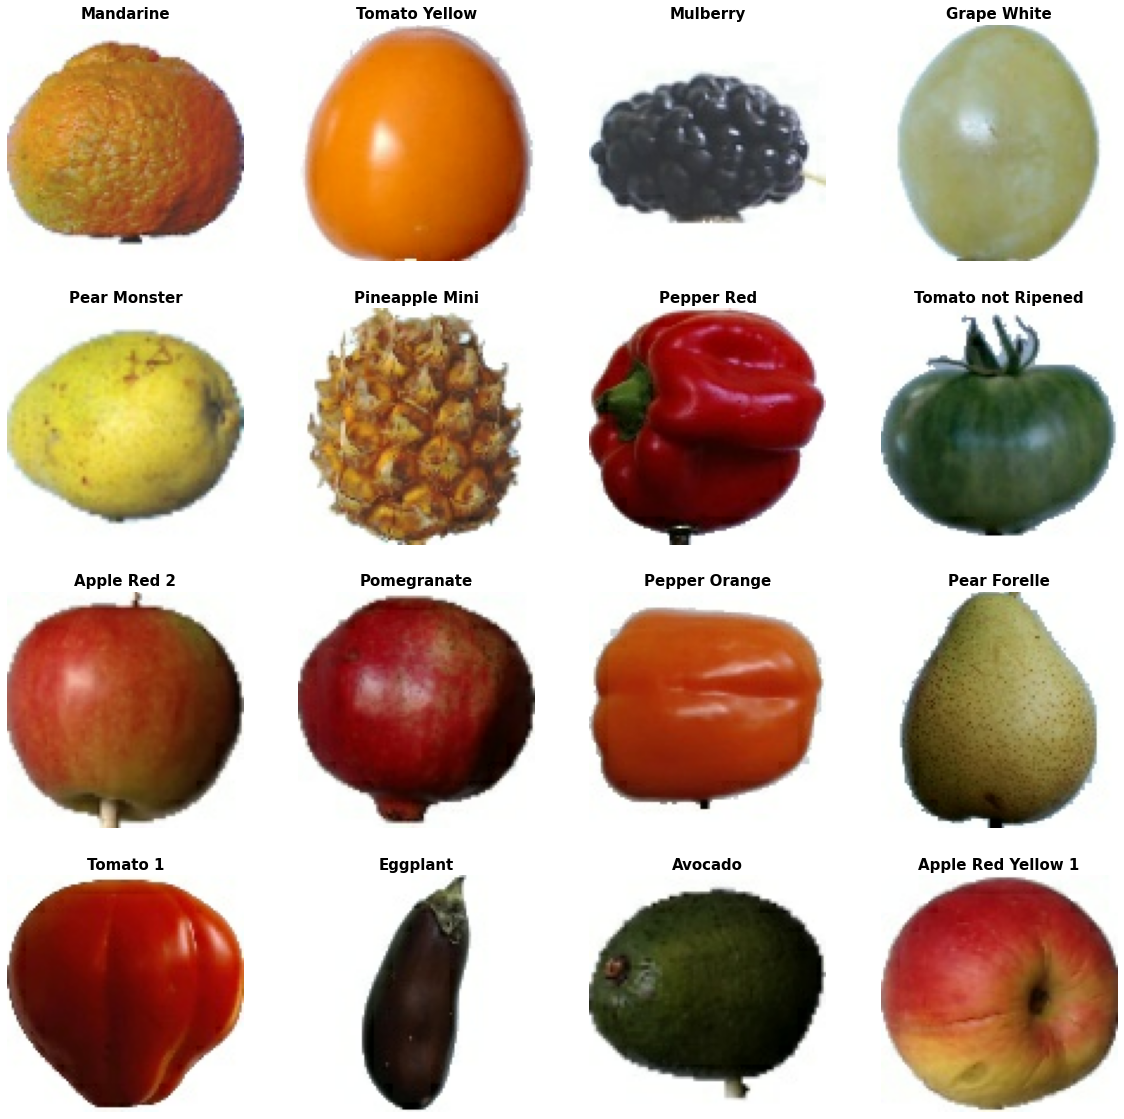

In [261]:
plt.figure(figsize=(4*PLOTS_SCALE,4*PLOTS_SCALE))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    
    idx = np.random.randint(0,len(train_images))
    
    plt.imshow(train_images[idx].astype("uint8"))
    plt.title(class_name(train_labels[idx]), fontsize=15, fontweight='bold')

***

# **Analisi delle Componenti Principali (PCA)**

L'analisi delle componenti principali ha lo scopo di ridurre il numero di dimensioni necessarie per descrivere un set di dati, senza ridurre in modo significativo la quantità d'informazione in essi contenuta.

In generale l'analisi delle componenti principali risulta utile per due motivi distinti:

1. Permette di ridurre la quantità di dati da trattare, e conseguentemente di velocizzare tutti i processi correlati all'analisi e all'elaborazione dei dati (come as esempio l'allenamento di un Neural Network)
2. Permette di identificare caratteristiche dei dati che potrebbero non essere evidenti dall'analisi nella base originaria

## Teoria
Considero un dataset rappresentato dalla matrice di design $ \bf{X} $, dove ciascuna riga rappresenta un campionamento in cui sono misurate $ p $ diverse caratteristiche:

$$
\mathbf{X}=\begin{bmatrix}
x_{0,0} & x_{0,1} & x_{0,2}& \dots & x_{0,p-1}\\
x_{1,0} & x_{1,1} & x_{1,2}& \dots & x_{1,p-1}\\
x_{2,0} & x_{2,1} & x_{2,2}& \dots & x_{2,p-1}\\
\dots & \dots & \dots & \dots & \dots\\
x_{n-2,0} & x_{n-2,1} & x_{n-2,2}& \dots & x_{n-2,p-1}\\
x_{n-1,0} & x_{n-1,1} & x_{n-1,2}& \dots & x_{n-1,p-1}\\
\end{bmatrix}=\begin{bmatrix} \boldsymbol{x}_0 & \boldsymbol{x}_1 & \boldsymbol{x}_2 & \dots & \boldsymbol{x}_{p-1}\end{bmatrix}
$$

Dalla matrice di design è possibile calcolare la matrice di covarianza, che è una matrice $p\times p$ delle correlazioni tra i vettori $\boldsymbol{x}_i$, le colonne di $ \bf{X} $:

$$
\mathbf{C}[\mathbf{X}] = \begin{bmatrix}
\mathrm{var}[\boldsymbol{x}_0] & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_2] &  \dots & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_0] & \mathrm{var}[\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_2] &  \dots & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_1] & \mathrm{var}[\boldsymbol{x}_2] &  \dots & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_{p-1}]\\
\dots & \dots & \dots & \dots & \dots  \\
\mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_1] & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_{2}]  & \dots  & \mathrm{var}[\boldsymbol{x}_{p-1}]\\
\end{bmatrix}
$$

Supponendo che le colonne di $ \bf{X} $ abbiano media nulla, è possibile calcolare la matrice di covarianza a partire dalla matrice di design:
$$
\mathbf{C}[\mathbf{X}] = \frac{1}{n}\mathbf{X}^T\mathbf{X}= \mathbb{E}[\mathbf{X}^T\mathbf{X}]
$$

Poiché la matrice di correlazione è simmetrica e definita positiva, è possibile diagonalizzarla con autovalori positivi:

$$
\mathbf{C}[\mathbf{X}] = \mathbf{V}\cdot\mathbf{\Sigma}^2\cdot\mathbf{V}^T
$$

dove $\mathbf{V}=\begin{bmatrix} \boldsymbol{v}_0 & \boldsymbol{v}_1 & \boldsymbol{v}_2 & \dots & \boldsymbol{v}_{p-1}\end{bmatrix}$ è un'opportuna matrice ortogonale e $\mathbf{\Sigma}=\mathrm{diag}(\lambda_0, \lambda_1, \lambda_2, \dots, \lambda_{p-1}) $ è una matrice diagonale in cui si può supporre che gli autovalori siano in ordine decrescente.

Gli autovettori $\boldsymbol{v}_i$ sono detti componenti principali di $\mathbf{X}$ e i $\lambda_i$ sono le varianze della distribuzione lungo le componenti principali.

### Teorema della Principal Component Analysis
Il sottospazio $ \mathrm{S}\in \mathbb{R}^\widetilde{p} $, con $ \widetilde{p} < p $, che massimizza la varianza della distribuzione è dato dai primi $ \widetilde{p} $ autovettori di $ \mathbf{C}[\mathbf{X}] $ corrispondenti ai primi $ \widetilde{p} $ autovalori più grandi.

***
## Analisi

L'analisi delle componenti principali è stata fatta utilizzando una <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html" target="_blank">funzione</a> di sklearn.

Il numero di componenti principali viene selezionato automaticamente in modo da mantenere una percentuale fissata della varianza dei dati:
* Mantenendo il 95% della varianza si ottengono 220 componenti principali, con una riduzione del numero di dimensioni superiore al 99%
* Mantenendo il 99% della varianza si ottengono 1379 componenti principali, con una riduzione del numero di dimensioni del 95.4%
* Mantenendo il 99.9% della varianza si ottengono 4668 componenti principali, con una riduzione del numero di dimensioni dell'84.4%

In [ ]:
pca95 = PCA(n_components=0.95, whiten=True)
pca99 = PCA(n_components=0.99, whiten=True)
pca999 = PCA(n_components=0.999, whiten=True)

# Utilizzo solo una parte del dataset, selezionata casualmente, poichè l'intero dataset è troppo grande per essere gestito da numpy
# (ValueError: Too large work array required -- computation cannot be performed with standard 32-bit LAPACK)
train_images_subset = np.random.permutation(train_images)[0:10000]

#Ci mette parecchio tempo
pca95.fit(train_images_subset.reshape(10000,100*100*3))
pca99.fit(train_images_subset.reshape(10000,100*100*3))
pca999.fit(train_images_subset.reshape(10000,100*100*3)) 

In [41]:
print('Componenti principali 95% varianza: ', pca95.components_.shape[0], sep='')
print('Componenti principali 99% varianza: ', pca99.components_.shape[0], sep='')
print('Componenti principali 99.9% varianza: ', pca999.components_.shape[0], sep='')

Componenti principali 95% varianza: 220
Componenti principali 99% varianza: 1379
Componenti principali 99.9% varianza: 4668


***
### Caricamento rapido modelli
Poichè il fit dei modelli di PCA richiede alcuni minuti i modelli sono stati salvati e possono essere rapidamente caricati

In [9]:
# Caricamento da file dei modelli
pca95, pca99, pca999 = load('SavedVariables/pca.txt')

***
Le prime 16 componenti principali ottenute sono state plottate con pyplot.\
E' evidente, osservando le prime componenti principali, che il dataset è composto principalmente da figure che occupano il centro dell'immagine e sono grossomodo circolari.

In [21]:
components95 = pca95.components_.reshape(len(pca95.components_),100,100,3)

In [22]:
MIN = components95.min()
MAX = components95.max()
components95_features = ((components95 - MIN) * (255/(MAX-MIN)))

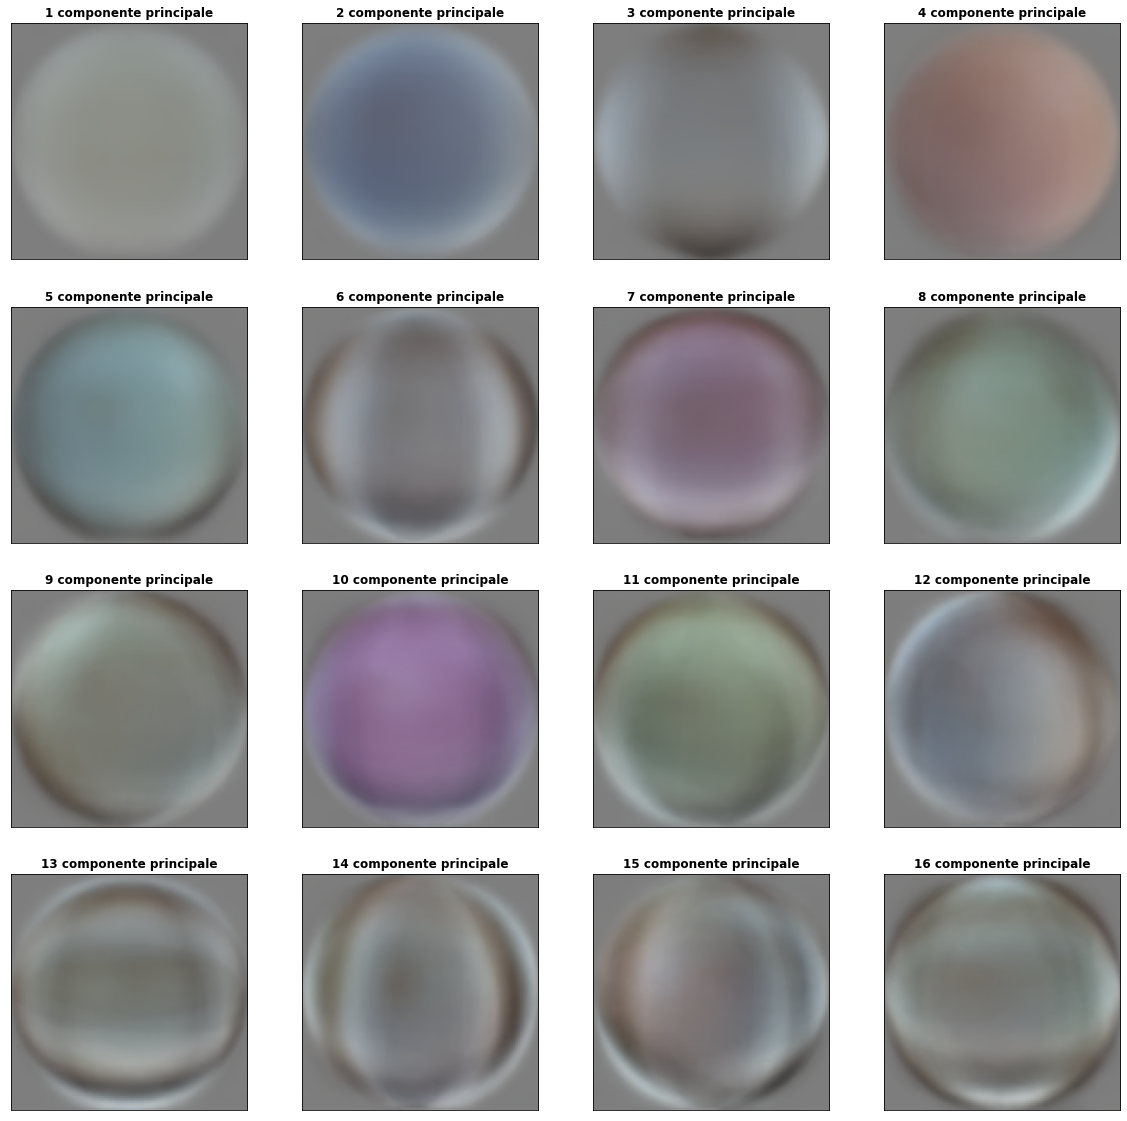

In [23]:
plt.figure(figsize=(4*PLOTS_SCALE,4*PLOTS_SCALE))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(components95_features[i].astype("uint8"))
    plt.title(str(i+1)+' componente principale',fontweight='bold')

***
Le immagini del dataset di training sono proiettate nel sottospazio di dimensione ridotta, e poi riproiettate nello spazio di dimensione (100 x 100 x 3) originario.\
Si nota come la riduzione di dimensionalità produca degli artefatti nelle immagini, oltre a una complessiva perdita di definizione. Tuttavia le immagini sono sufficientemente chiare da poter distinguere la classe di appartenenza, nonostante la grandissima riduzione di dati necessari a descriverle

In [77]:
train_images_reduced95 = pca95.inverse_transform(pca95.transform(train_images.reshape(len(train_images),100*100*3))).reshape(len(train_images), 100, 100, 3)
train_images_reduced99 = pca99.inverse_transform(pca99.transform(train_images.reshape(len(train_images),100*100*3))).reshape(len(train_images), 100, 100, 3)
train_images_reduced999 = pca999.inverse_transform(pca999.transform(train_images.reshape(len(train_images),100*100*3))).reshape(len(train_images), 100, 100, 3)

In [46]:
# Caricamento rapido da file
train_images_reduced95, train_images_reduced99, train_images_reduced999 = load('SavedVariables/trainImagesReduced.txt')

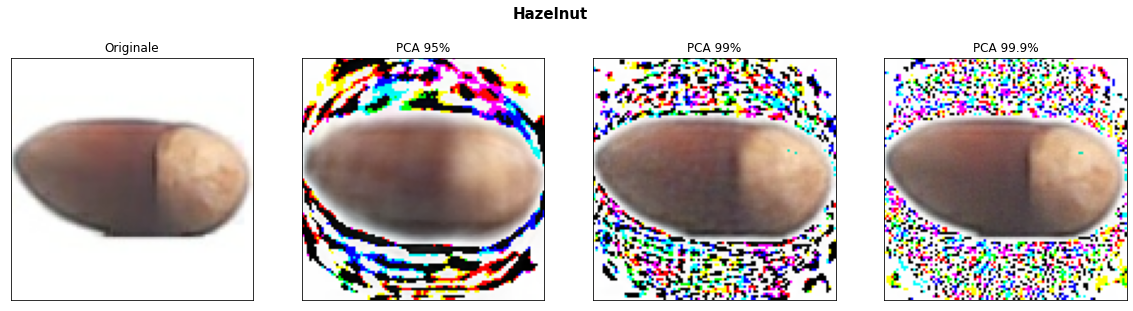

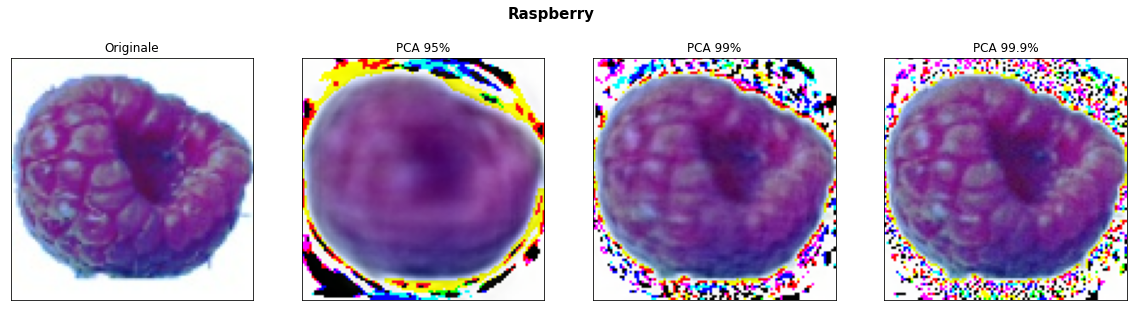

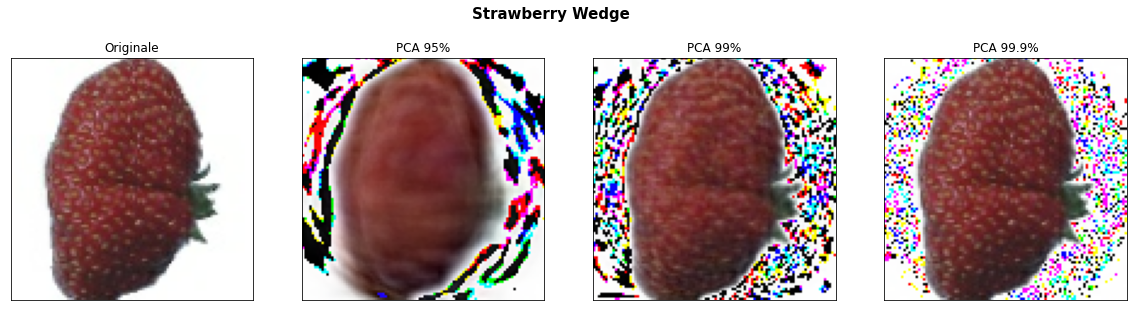

In [66]:
for i in range(3):
    idx = np.random.randint(0,len(train_images))
    
    fig = plt.figure(figsize=(4*PLOTS_SCALE,PLOTS_SCALE))
    fig.suptitle(class_name(train_labels[idx]), fontsize=15, fontweight='bold')
    
    plt.subplot(1,4,1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[idx].astype("uint8"))
    plt.title('Originale')
    
    plt.subplot(1,4,2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_reduced95[idx].astype("uint8"))
    plt.title('PCA 95%')
    
    plt.subplot(1,4,3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_reduced99[idx].astype("uint8"))
    plt.title('PCA 99%')
    
    plt.subplot(1,4,4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_reduced999[idx].astype("uint8"))
    plt.title('PCA 99.9%')

***
# **Ottimizzazione degli Iperparametri e Training del modello**

## Reti Neurali
Le Reti Neurali sono dei modelli computazionali costituiti da una serie di *neuroni*, organizzati in *strati*. Il primo strato, detto di input, contiene le caratteristiche dei dati di input. Ciascun neurone negli strati successivi ha un valore di attivazione che dipende da tutti i neuroni dello strato precedente tramite una combinazione lineare, e il passaggio attraverso una *funzione di attivazione* non lineare:

$$
z = \sum_{i=1}^n w_i a_i + b \hspace{3cm} y = f(z) ,
$$

dove $f$ è la funzione di attivazione, $a_i$ rappresenta l'output del neurone $i$-esimo dello strato precedente, $w_i$ è il peso dato all'input $i$ e $b$ è un *bias* che permette di rappresentare un maggior numero di valori alla Rete Neurale (in quanto altrimenti input uguali a 0 sarebbero inevitabilmente mappati ad output nulli).

### Reti Neurali Convoluzionali
Le Reti Neurali Convoluzionali (CNN) sono una tipologia di Network Neurale particolarmente utile per la classificazione di immagini.

Le immagini ed altri tipi di dati simili (ad esempio video e audio) condividono caratteristiche importanti:
1. sono salvati in array multidimensionali contenenti un grande numero di dati
2. esistono uno o più assi in cui è presente una correlazione spaziale (come nei pixel di una figura)
3. esiste un asse (*channel axis*) che permette di accedere a diverse visualizzazioni dei dati (come pixel di colori diversi in una figura rgb)

Una rete neurale "classica" (Feed Forward Neural Network) non sfrutta queste caratteristiche: l'ordinamento dei dati non è tenuto in considerazione. Inoltre il grande numero di dati di input porta ad un aumento esponenziale dei parametri della rete, rendendo poco praticabile l'addestramento.

Le Reti Neurali Convoluzionali sfruttano una convoluzione discreta per estrarre caratteristiche locali dei dati di input, mantenendone la correlazione spaziale ed utilizzando un numero limitato di parametri.\
Contrariamente a una rete neurale Feed Forward, i neuroni degli strati interni di una rete neurale convoluzionale sono connessi solo ad una regione dei dati di input e sono disposti in una struttura tridimensionale.

Ciascun livello di convoluzione di un CNN contiene diverse componenti:

* Lo strato di **Convoluzione** calcola il prodotto scalare tra una matrice di pesi e una piccola regione dello spazio di input, ottenendo come output un volume di neuroni con una profondità dipendente dal numero di filtri che si sceglie di usare
* Lo strato di **Attivazione** applica una funzione non lineare (spesso della famiglia ReLU) all'output dello strato di convoluzione
* Lo strato di **Pooling** effettua un'operazione di downsampling lungo gli assi spaziali del volume di neuroni (non la profondità) per ridurne la dimensionalità

L'output di una serie di livelli di convoluzione è un volume di neuroni di dimensione notevolmente ridotta rispetto allo strato di input, e in cui ciascun neurone rappresenta una determinata caratteristica spaziale dei dati di input, dipendente dai filtri utilizzati negli strati di convoluzione.

Spesso vengono aggiunti dopo una serie di strati di convoluzione uno o più strati Fully Connected, che ottengono le previsioni finali della rete neurale.

***

## Training del modello
E' stata scritta una funzione `makeModel`, che crea un modello con iperparametri e architettura parzialmente selezionabili dall'utente. In particolare è possibile scegliere:
* il numero di livelli di convoluzione (convoluzione + attivazione + pooling) (`nConvLayers`)
* le dimensioni della finestra di convoluzione (`kernelSize`)
* il passo di cui si muove la finestra di convoluzione (`stride`)
* il numero di filtri nel primo livello (avanzando ad ogni eventuale livello di convoluzione successivo i filtri vengono raddoppiati) (`nFiltersFirstLayer`)
* la funzione di attivazione dei neuroni nei livelli di convoluzione (`convLayersActivation`)
* le dimensioni della finestra di pooling (`maxPoolingSize`)
* il numero di strati densi alla fine della rete neurale, e prima dello strato di output (`nDenseLayers`)
* il numero di neuroni in ciascuno strato denso (`nDenseNeurons`)
* la funzione di attivazione dei neuroni negli strati densi (`denseLayersActivation`)
* l'algoritmo di ottimizzazione per il Learning Rate nella discesa del gradiente (`optimizer`)

Un'altra funzione (`trainModel`) invece mette in atto l'addestramento del modello selezionato.\
Il numero di epoche non è fissato a priori (se non per un limite superiore di 500), ma è utilizzato il metodo dell'**early stopping**: l'addestramento continua finchè il valore della funzione di costo, valutata sul set di validation, non migliora per un numero fissato di epoche di almeno una costante selezionata. In particolare si è scelto di terminare il trainign quando la funzione di costo non migliora di più di $ 10^{-3} $ per 5 epoche. Poichè il numero ottimale di epoche potrebbe dipendere dagli iperparametri scelti, l'early stopping permette una maggiore flessibilità, riducendo però fortemente il rischio di overfitting.

Nell'addestramento del CNN **non** sono stati usati i dati ridotti tramite PCA, ma il dataset originario. La scelta deriva dal fatto che la PCA elimina la caratteristica delle immagini per cui è necessario l'uso di un CNN, ovvero la correlazione spaziale tra i dati di input, oltre che la loro multidimensionalità.\
Sarebbe corretto, dopo aver applicato la PCA, utilizzare un Network Feed Forward fully connected, che permette di estrarre tutte le possibili relazioni tra le componenti principali, anche se "distanti" nel vettore di input. E' ragionevole aspettarsi che la precisione ottenibile con la combinazione PCA + FFNN sia inferiore a quella del CNN, in quanto parte dell'informazione è stata rimossa dal dataset. Tuttavia il modello sarebbe certamente molto più veloce da allenare, e quindi molto più facilmente ottimizzabile al massimo delle sue potenzialità.

### Ottimizzazione degli Iperparametri e dell'architettura
Per ottimizzare la rete neurale è stato usato il pacchetto <a href="https://github.com/hyperopt/hyperopt" target="_blank">Hyperopt</a>.

Questo pacchetto attua una strategia bayesiana di ricerca degli iperparametri ottimali. I risultati delle iterazioni precedenti sono utilizzati per identificare le regioni più promettenti dello spazio degli iperparametri, nelle quali i punti sono campionati più densamente.\
Con questo metodo si ottiene una convergenza ai parametri ottimali più rapida non solo di una Grid Search (che spesso è impraticabile quando si cerca di ottimizzare numerosi iperparametri contemporaneamente, a causa della *curse of dimensionality*), ma anche di una Random Search.\
(<a href="http://proceedings.mlr.press/v28/bergstra13.pdf" target="_blank">Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.</a>)

Poichè il numero di parametri selezionabili dall'utente nella funzione `makeModel` è molto elevato, e ciascun allenamento dell'algoritmo richiede diversi minuti (~ 30 min), si è scelto di fissarne alcuni per ridurre i tempi di ottimizzazione (dopo alcune prove "manuali"):
1. E' stata testata la dipendenza dalla funzione di attivazione dei neuroni degli strati di convoluzione e degli strati densi (tra ReLU e ELU). Non essendo stata evidenziata particolare differenza tra le due opzioni si è scelta la ELU, in quanto essa è, generalmente, la più efficace, poichè previene la formazione di *dead neurons* (ovvero di neuroni il cui peso non viene mai modificato a causa della derivata nulla per input negativi)
2. Come algoritmo di ottimizzazione del learning rate è stato scelto <a href="https://arxiv.org/abs/1412.6980" target="_blank">Adam</a>


In [217]:
def makeModel (I = {}):
    #parametri di default
    var = {'nConvLayers' : 3,
           'nFiltersFirstLayer' : 16,
           'kernelSize' : 3, 
           'stride' : 1,
           'maxPoolingSize' : 4,
           'convLayersActivation' : 'elu',
           'nDenseLayers' : 1,
           'nDenseNeurons' : 128,
           'denseLayersActivation' : 'elu',
           'optimizer' : 'adam',
           'printSummary' : False
          }
    var.update(I)
    
    model = Sequential()
    
    #rescaling -> trasforma i valori rgb dei pixel in [0,255] in valori in [0,1]
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(100, 100, 3)))
    
    #convolutional
    for N in range(var['nConvLayers']):
        model.add(layers.Conv2D((2**N) * var['nFiltersFirstLayer'], (var['kernelSize'],var['kernelSize']), strides=(var['stride'],var['stride']), padding='same', activation=var['convLayersActivation']))
        if N==var['nConvLayers']-1:
            model.add(layers.MaxPooling2D((var['maxPoolingSize'],var['maxPoolingSize'])))
        else:
            model.add(layers.MaxPooling2D())
            
    #dense feed forward
    model.add(layers.Flatten())
    for M in range(var['nDenseLayers']):
        model.add(layers.Dense(var['nDenseNeurons'], activation=var['denseLayersActivation']))
    
    #output
    model.add(layers.Dense(131, activation="softmax"))
    
    #compiling
    model.compile(optimizer=var['optimizer'], loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    '''
    tf.keras.losses.SparseCategoricalCrossentropy è cross entropy che prende in input i valori y_true codificati come un singolo intero, anzichè come vettori categorici (0,0,...,1,..0)
    per valori y_true con one-hot encoding --> tf.keras.losses.CategoricalCrossentropy
    
    Suppone che sia già stata applicata la softmax all'ultimo layer (valori di output normalizzati) -> altrimenti aggiungere argomento: from_logits=True
    
    https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
    '''
    
    #summary
    if var['printSummary']:
        model.summary()
    
    return model


def trainModel(model):
    #impostazione dell'early stopping
    early_stopping = EarlyStopping(
        min_delta=1e-3,
        patience=5,
        restore_best_weights=True
    )

    #training
    history = model.fit(
        train_images, train_labels,
        batch_size=250,
        validation_data=(val_images, val_labels),
        callbacks=[early_stopping],
        epochs=500,
        verbose=1
    )
    
    return history

***
Lo spazio degli iperparametri da ottimizzare è definito usando funzioni di hyperopt

In [86]:
hp_space = {
    'nConvLayers' : hp.randint('nConvLayers', 3) + 1,
    'nFiltersFirstLayer' : hp.randint('nFiltersFirstLayer', 40) + 10,
    'kernelSize' : hp.randint('kernelSize', 5) + 2,
    'stride' : hp.randint('stride', 3) + 1 ,
    'maxPoolingSize' : hp.randint('maxPoolingSize', 3) + 2,
    'nDenseLayers': hp.randint('nDenseLayers', 2) + 1,
    'nDenseNeurons': hp.randint('nDenseNeurons',250) + 50,
}

Ed è definita una funzione `objective` che costruisce un modello usando gli iperparametri passati come argomento e lo allena, per poi restituire il valore della funzione di costo sul dataset di validation.

Alcune combinazioni di iperparametri non possono generare un modello valido (con troppi livelli di convoluzione, grandi finestre di pooling o *stride* elevato, le dimensioni dei dati di input non sono sufficienti a superare tutti i downsampling ed a raggiungere lo strato finale).\
In questi casi la funzione `objective` memorizza il fallimento e procede con il tentativo successivo.

In [30]:
def objective(hyperparams):
    try:
        model = makeModel(hyperparams)
        print('Testing Hyperparams: ', hyperparams, '   ',end='', sep='')
        history = trainModel(model)
        results = {
                    'loss' : min(history.history['val_loss']),
                    'status' : STATUS_OK,
                    'space' : hyperparams
                    'history': history
                  }
        print('Accuracy = ', max(history.history['val_accuracy']))
    except:
            results = {
                        'loss' : None,
                        'status' : STATUS_FAIL,
                        'space' : hyperparams
                       }
    return results

Infine sono testate 100 combinazioni diverse di iperparametri ed è salvata la migliore

In [31]:
trialsObj = Trials()

In [ ]:
bestParams = fmin(objective, space=hp_space, trials=trialsObj, max_evals=100, algo=tpe.suggest)

Testing Hyperparams:                                   
{'kernelSize': 4, 'maxPoolingSize': 3, 'nConvLayers': 2, 'nDenseLayers': 2, 'nDenseNeurons': 279, 'nFiltersFirstLayer': 36, 'stride': 1}
Accuracy =                                             
1.0                                                    
Testing Hyperparams:                                                                     
{'kernelSize': 5, 'maxPoolingSize': 2, 'nConvLayers': 2, 'nDenseLayers': 1, 'nDenseNeurons': 175, 'nFiltersFirstLayer': 40, 'stride': 2}
Accuracy =                                                                               
1.0                                                                                        
Testing Hyperparams:                                                                        
{'kernelSize': 6, 'maxPoolingSize': 2, 'nConvLayers': 1, 'nDenseLayers': 1, 'nDenseNeurons': 204, 'nFiltersFirstLayer': 35, 'stride': 3}
Accuracy =                                              

I parametri migliori ottenuti sono:

In [196]:
bestParams = {
    'kernelSize' : 3,
    'makPoolingSize' : 5,
    'nConvLayers' : 3,
    'nDenseLayers' : 1,
    'nDenseNeurons' : 128,
    'nFiltersFirstLayers' : 16,
    'stride' : 1,
}

***
Il modello migliore è allenato e salvato su file per poterlo caricare rapidamente

In [218]:
model_best = makeModel(bestParams)
model_best.summary()
hist_best = trainModel(model_best)

model_best.save('SavedVariables/model_best.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)         

In [25]:
#caricamento rapido da file
model_best = tf.keras.models.load_model('SavedVariables/model_best.h5')
hist_best = load('SavedVariables/training_History.txt')

***
# **Valutazione del Modello e stima dell'Errore Medio di Previsione**



## Andamento della funzione di costo e della precisione sui set di training e validation nelle epoche di Training
Per studiare l'andamento del training del modello selezionato da Hyperopt, ed assicurarsi che non ci sia stato overfitting, sono disegnati i grafici dell'andamento della funzione di costo e dell'accuratezza al variare dell'epoca dell'addestramento sul dataset di training e di validation.
La similitudine nella forma delle curve, unita al fatto che la loss del validation dataset non ha un minimo prima dell'ultima epoca conferma che il modello non sia overfitted.

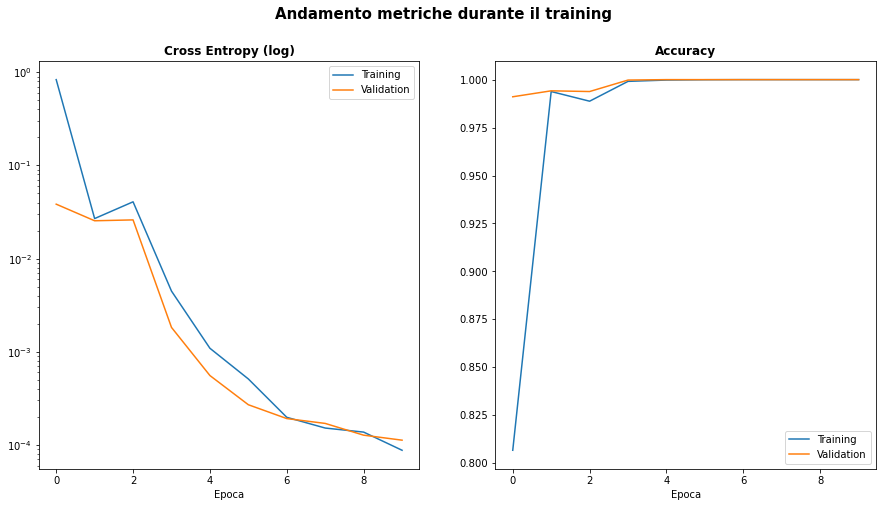

In [26]:
if type(hist_best)!=dict:
    hist_best = hist_best.history

train_acc = hist_best['accuracy']
val_acc = hist_best['val_accuracy']

train_loss = hist_best['loss']
val_loss = hist_best['val_loss']

fig = plt.figure(figsize=(3*PLOTS_SCALE, 1.5*PLOTS_SCALE))
fig.suptitle('Andamento metriche durante il training', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Cross Entropy (log)', fontweight='bold')
plt.yscale('log')
plt.xlabel('Epoca')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='lower right')
plt.xlabel('Epoca')
plt.title('Accuracy', fontweight='bold');

***
## Errore del modello sul dataset di Test

L'errore del modello è stimato ottenendo le previsioni del dataset di test, e confontandole con i valori veri.

In [27]:
test_loss, test_acc = model_best.evaluate(test_images, test_labels, verbose=0)
print('Il modello ha ottenuto un\'accuratezza sul dataset di training del {:.2%}'.format(test_acc))

Il modello ha ottenuto un'accuratezza sul dataset di training del 97.23%


***
## Previsioni sul dataset di test

La previsione di alcune immagini del dataset di test è stata analizzata e graficata: è stato disegnato un istogramma rappresentante i valori di output del CNN (per le 5 classi con maggiore probabilità).

Si nota che, tra le immagini classificate in modo **non** corretto, spesso la rete neurale ha valori di output distribuiti su diverse classi, contrariamente alle immagini classificate correttamente, dove invece la classe selezionata ha spesso probabilità vicina al 100%. Questo non è sempre vero, tuttavia, ed accade anche che il CNN dia un risultato errato con confidenza prossima al 100%.\
Tra le immagini classificate correttamente, il 96% è classificato con output superiore a 0.9; tra le immagini classificate erroneamente, invece, solo il 37% supera tale valore.

In [226]:
test_pred = model_best.predict(test_images)

In [227]:
#vettore booleano di lunghezza len(test_images) che dice per ogni immagine se è classificata correttamente o erroneamente dal modello
correct_idx = test_labels == np.array([output.argmax() for output in test_pred])

In [269]:
def drawHistPred(images, labels, predictions, n=3):
    for i in range(n): 
        #scelgo un indice casuale
        idx = np.random.randint(0,len(images))

        #salvo l'immagine corrispodente
        img = tf.expand_dims(images[idx], 0) 

        #ottengo dall'output del CNN le previsioni e le classi
        top5_preds = [class_name(i) for i in predictions[idx].argsort()[-1:-6:-1]]
        top5_scores = [predictions[idx][i]*100 for i in predictions[idx].argsort()[-1:-6:-1]]

        fig = plt.figure(figsize=(4*PLOTS_SCALE,PLOTS_SCALE))
        fig.suptitle('$\mathbf{True:}$ '+class_name(labels[idx])+' - $\mathbf{Predicted:}$ '+top5_preds[0], fontsize=15)

        plt.subplot(1,2,1)
        plt.axis('off')
        plt.imshow(images[idx].astype("uint8"))

        if predictions[idx].argsort()[-1] == labels[idx]:
            color = 'darkgreen'
        else:
            color = 'red'
        
        plt.subplot(1,2,2)
        plt.bar(top5_preds, top5_scores, width=0.5, color=color)
        plt.ylabel('Probabilità [%]')
        plt.title('Output CNN')

#### Immagini classificate correttamente

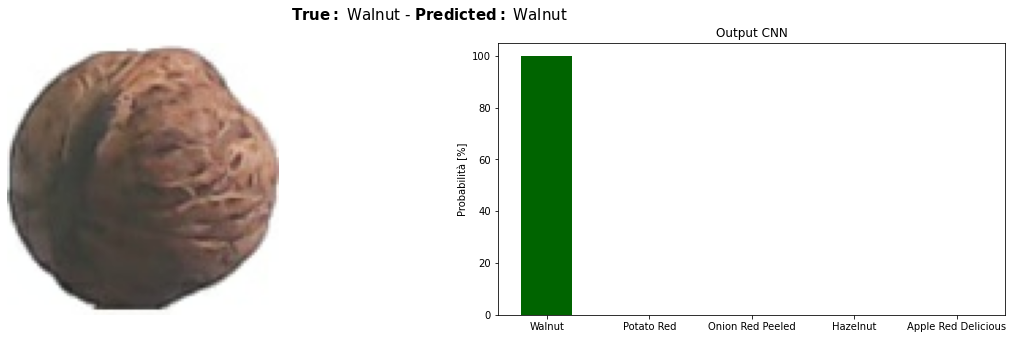

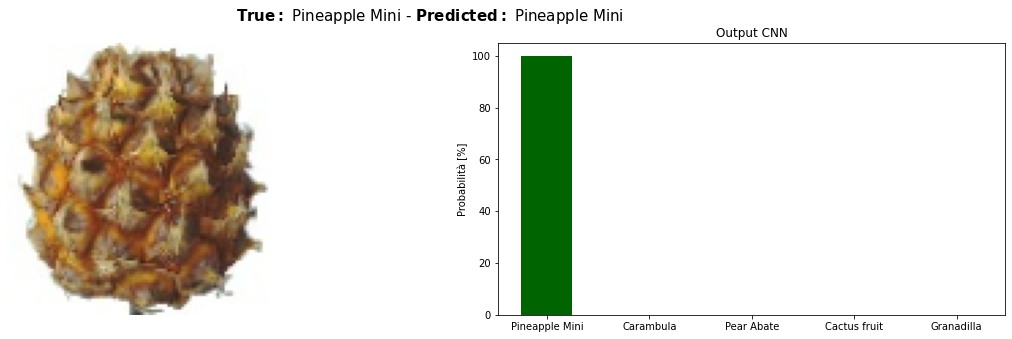

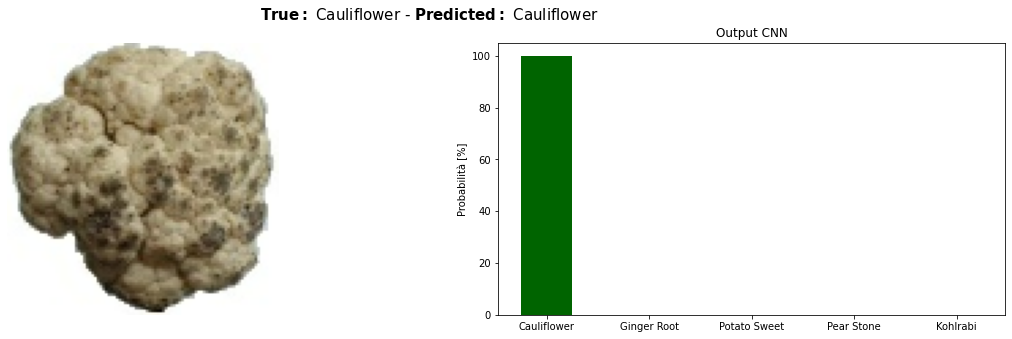

In [270]:
test_images_correct = test_images[correct_idx==True]
labels_correct = test_labels[correct_idx==True]
pred_correct = test_pred[correct_idx==True]

drawHistPred(test_images_correct, labels_correct, pred_correct)

#### Immagini classificate erroneamente

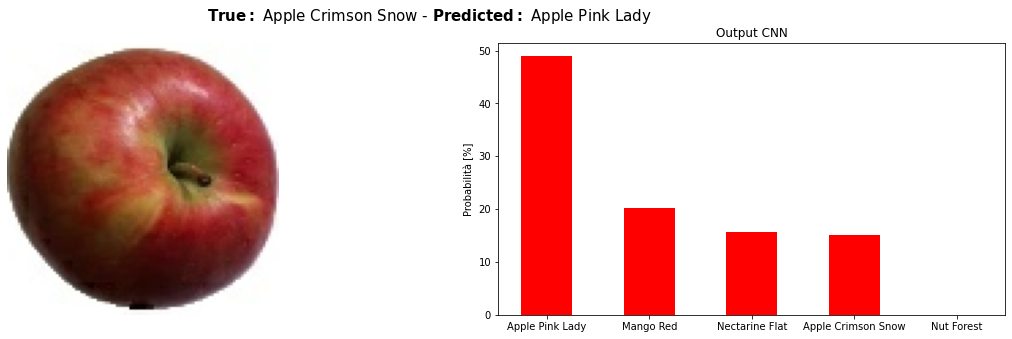

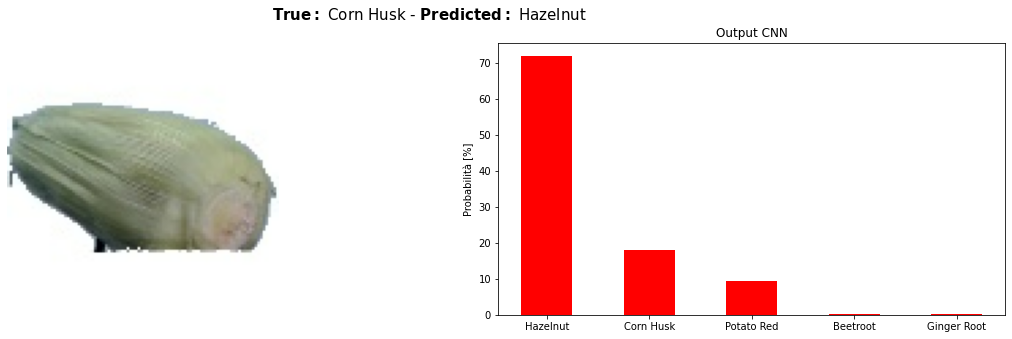

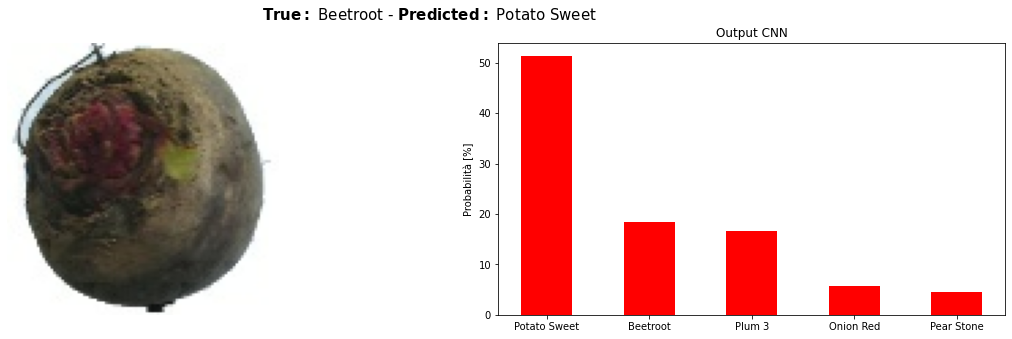

In [281]:
test_images_incorrect = test_images[correct_idx==False]
labels_incorrect = test_labels[correct_idx==False]
pred_incorrect = test_pred[correct_idx==False]

drawHistPred(test_images_incorrect, labels_incorrect, pred_incorrect)

***
# **Sviluppo di un FFNN che prende in input le componenti principali**

Per verificare quanto variasse l'errore utilizzando una rete neurale feed forward che prende in input le componenti principali dei dati, è stato fatto un breve training di un FFNN sui dati proiettati nella base di componenti principali che mantiene il 95% della varianza.

La rete neurale è addestrata in modo estremamente più veloce, e mantiene una buona accuratezza, intorno all'86%.

In [247]:
train_images_princComp = pca95.transform(train_images.reshape(len(train_images),100*100*3))
val_images_princComp = pca95.transform(val_images.reshape(len(val_images),100*100*3))
test_images_princComp = pca95.transform(test_images.reshape(len(test_images),100*100*3))

In [249]:
# Caricamento rapido da file
train_images_princComp, val_images_princComp, test_images_princComp = load('SavedVariables/images_princComp.txt')

In [250]:
FFNN_model = Sequential()

#Dense
FFNN_model.add(layers.Dense(150, activation='elu', input_shape=(train_images_princComp.shape[-1],)))

#Output
FFNN_model.add(layers.Dense(131, activation='softmax'))

#Compiling
FFNN_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

#Summary
FFNN_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 150)               33150     
_________________________________________________________________
dense_14 (Dense)             (None, 131)               19781     
Total params: 52,931
Trainable params: 52,931
Non-trainable params: 0
_________________________________________________________________


In [251]:
#Training
early_stopping = EarlyStopping(
    min_delta=1e-3,
    patience=5,
    restore_best_weights=True
)

hist_ff = FFNN_model.fit(
    train_images_princComp, train_labels,
    batch_size=250,
    validation_data=(val_images_princComp, val_labels),
    callbacks=[early_stopping],
    epochs=500,
    verbose=1
)

Epoch 1/500
217/217 [==============================] - 1s 4ms/step - loss: 3.3567 - accuracy: 0.3761 - val_loss: 0.5660 - val_accuracy: 0.9154
Epoch 2/500
217/217 [==============================] - 1s 3ms/step - loss: 0.3694 - accuracy: 0.9519 - val_loss: 0.1547 - val_accuracy: 0.9834
Epoch 3/500
217/217 [==============================] - 1s 3ms/step - loss: 0.1062 - accuracy: 0.9916 - val_loss: 0.0705 - val_accuracy: 0.9940
Epoch 4/500
217/217 [==============================] - 1s 3ms/step - loss: 0.0479 - accuracy: 0.9981 - val_loss: 0.0408 - val_accuracy: 0.9971
Epoch 5/500
217/217 [==============================] - 1s 3ms/step - loss: 0.0267 - accuracy: 0.9994 - val_loss: 0.0271 - val_accuracy: 0.9983
Epoch 6/500
217/217 [==============================] - 1s 3ms/step - loss: 0.0170 - accuracy: 0.9999 - val_loss: 0.0196 - val_accuracy: 0.9985
Epoch 7/500
217/217 [==============================] - 1s 3ms/step - loss: 0.0118 - accuracy: 0.9999 - val_loss: 0.0151 - val_accuracy: 0.9990

In [254]:
#Caricamento rapido da file
FFNN_model = tf.keras.models.load_model('SavedVariables/FFNN_model.h5')

## Valutazione del modello e predizione di alcune immagini di test

In [255]:
FFNN_model.evaluate(test_images_princComp, test_labels)

709/709 [==============================] - 1s 696us/step - loss: 0.6590 - accuracy: 0.8633


[0.6590246558189392, 0.8632757663726807]

In [283]:
test_pred_FFNN = FFNN_model.predict(test_images_princComp)

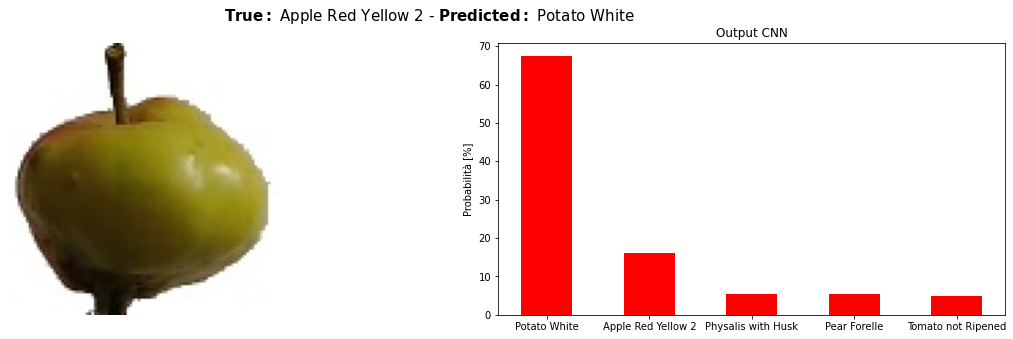

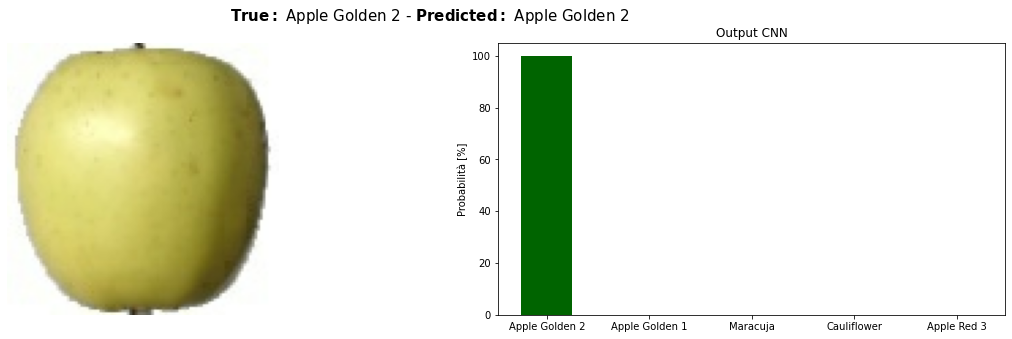

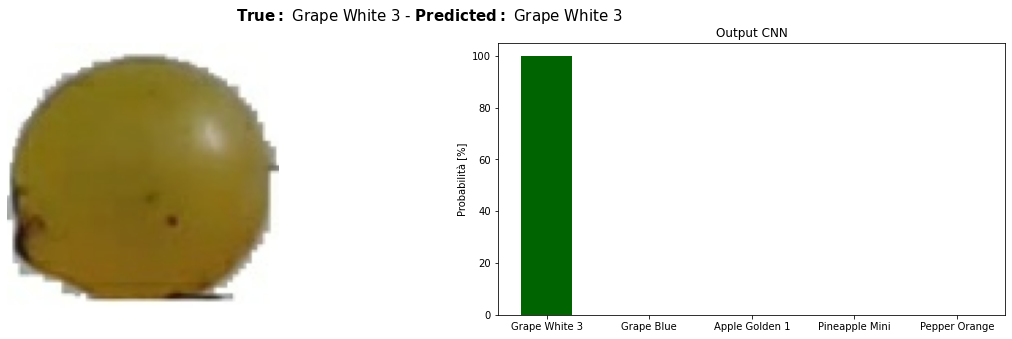

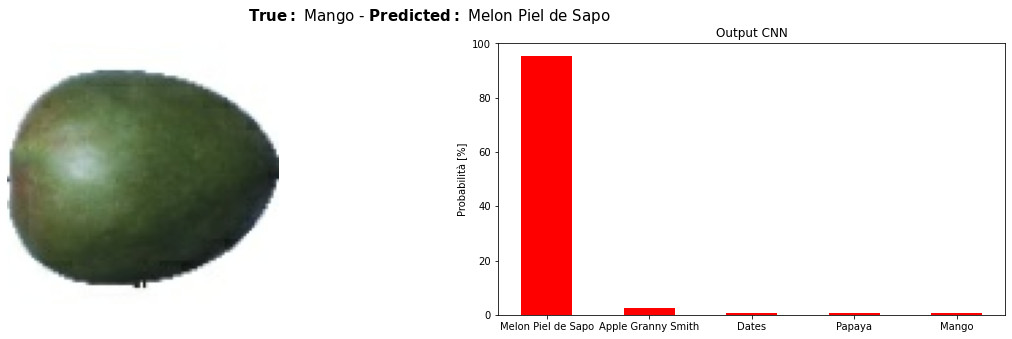

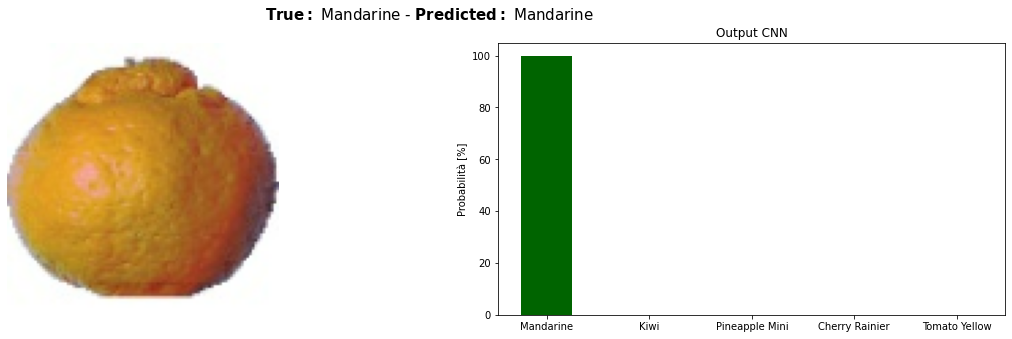

In [298]:
drawHistPred(test_images, test_labels, test_pred_FFNN, n=5)